## Processing sensor data from Shale Hills CZO SPVF site ##

- Marc Berghouse 8/8/2020: Original format
- Zach Perzan 9/23/202: Improved format and working PRISM concat

This array includes:
- Apogee Instruments SO-110 O2 sensors
- Eosense EosGP CO2 sensors

Other data includes:
- PRISM daily precipitation




In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
infiles= ["../../raw_data/Shale Hills/SPVF/SPVF_SiTS_CO2.csv",
         "../../raw_data/Shale Hills/SPVF/SPVF_SiTS_Oxygen.csv"]
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Shale Hills/Precipitation/PRISM_Shale_Hills_provisional.csv" 
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=["Record", "CO2lo_50cm.ppm","CO2hi_50cm.ppm","GPTemp_50cm.deg.C" , "CO2lo_70cm.ppm",
         "CO2hi_70cm.ppm", "GPTemp_70cm.deg.C", "O2_50cm.percent.0-100",
         "DiffVolt_50cm.mV", "ApogeeTemp_50cm.deg.C",  "O2_70cm.percent.0-100", "DiffVolt_70cm.mV",
         "ApogeeTemp_70cm.deg.C"]


# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2014-01-01', '2020-03-18 '), errors='ignore')
ppt = ppt.drop(pd.date_range('2020-07-21', '2020-08-02'), errors='ignore')


hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

In [4]:
df=df.drop(columns="Record")
df=df.drop(columns="DiffVolt_50cm.mV")
df=df.drop(columns="DiffVolt_70cm.mV")


In [5]:
#We should probably move CO2 data to the top so that we can define start_remove and end_remove before we use it for other columns
start_remove = pd.to_datetime('2020-06-05')
end_remove = pd.to_datetime('2020-06-24')


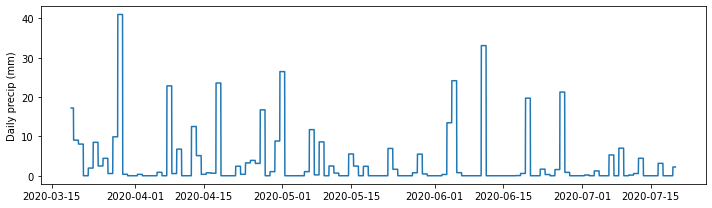

In [6]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

In [7]:
df['PRISM_precip.mm']=df['PRISM_precip.mm'].loc[(df.index < start_remove) | (df.index > end_remove)]


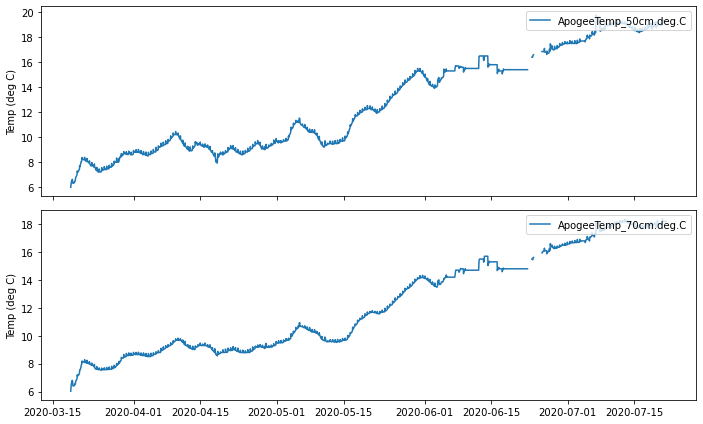

In [8]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');


In [9]:
df['ApogeeTemp_50cm.deg.C']=df['ApogeeTemp_50cm.deg.C'].loc[(df.index < start_remove) | (df.index > end_remove)]
df['ApogeeTemp_70cm.deg.C']=df['ApogeeTemp_70cm.deg.C'].loc[(df.index < start_remove) | (df.index > end_remove)]


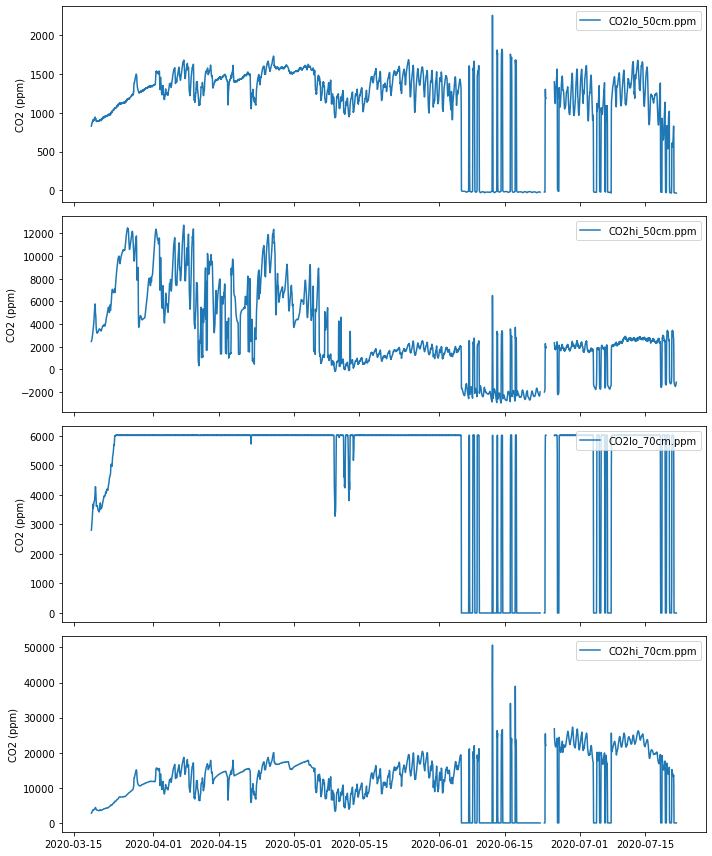

In [10]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [11]:
mask = df['CO2lo_50cm.ppm'] < 5000
df.loc[mask, 'CO2_50cm.ppm'] = df.loc[mask, 'CO2lo_50cm.ppm']
df.loc[~mask, 'CO2_50cm.ppm'] = df.loc[~mask, 'CO2hi_50cm.ppm']
mask2 = df['CO2lo_70cm.ppm'] < 5000
df.loc[mask2, 'CO2_70cm.ppm'] = df.loc[mask2, 'CO2lo_70cm.ppm']
df.loc[~mask2, 'CO2_70cm.ppm'] = df.loc[~mask2, 'CO2hi_70cm.ppm']

In [12]:
df=df.drop(columns='CO2lo_50cm.ppm')
df=df.drop(columns='CO2lo_70cm.ppm')
df=df.drop(columns='CO2hi_50cm.ppm')
df=df.drop(columns='CO2hi_70cm.ppm')



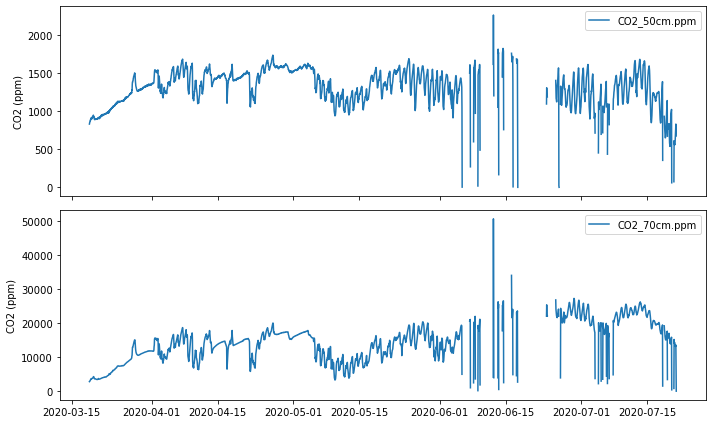

In [13]:
# Plot CO2 data
df['CO2_50cm.ppm'].mask(df['CO2_50cm.ppm']<=0, inplace=True)
df['CO2_70cm.ppm'].mask(df['CO2_70cm.ppm']<=0, inplace=True)


co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');



In [14]:
#Only use good CO2 data, and remove data from other columns based on good CO2 data


df['CO2_50cm.ppm']=df['CO2_50cm.ppm'].loc[(df.index < start_remove) | (df.index > end_remove)]
df['CO2_70cm.ppm']=df['CO2_70cm.ppm'].loc[(df.index < start_remove) | (df.index > end_remove)]


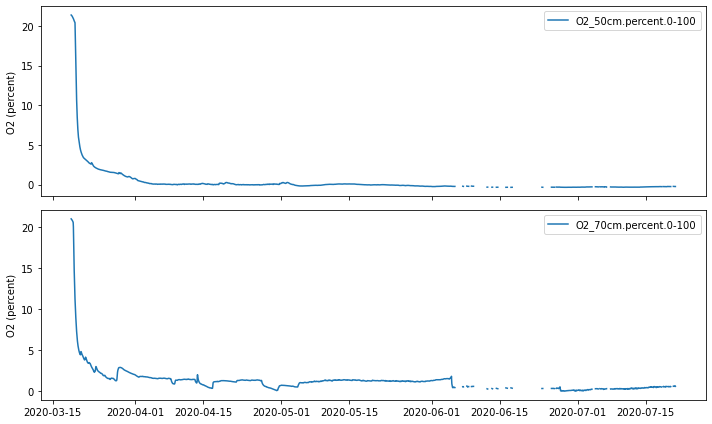

In [15]:
# Plot O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

In [16]:
df['O2_50cm.percent.0-100']=df['O2_50cm.percent.0-100'].loc[(df.index < start_remove) | (df.index > end_remove)]
df['O2_70cm.percent.0-100']=df['O2_70cm.percent.0-100'].loc[(df.index < start_remove) | (df.index > end_remove)]

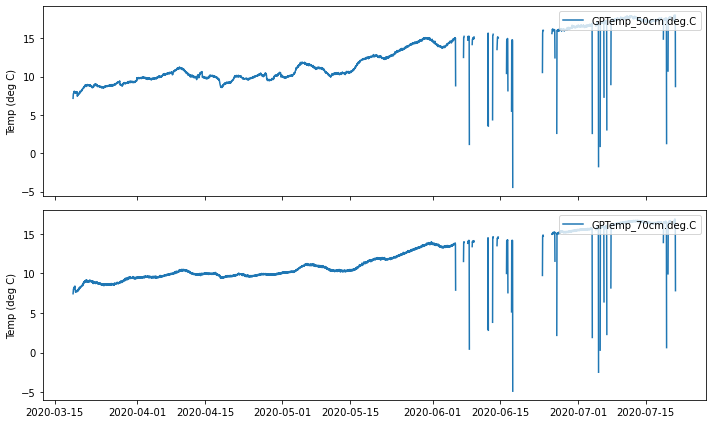

In [17]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'GPTemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [18]:
df=df.drop(columns='GPTemp_50cm.deg.C')
df=df.drop(columns='GPTemp_70cm.deg.C')



In [19]:
output=df.copy()
outfile = '../../processed_data/Shale_Hills/SPVF_CO2_O2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.EST')

In [20]:
output

,O2_50cm.percent.0-100,ApogeeTemp_50cm.deg.C,O2_70cm.percent.0-100,ApogeeTemp_70cm.deg.C,PRISM_precip.mm,CO2_50cm.ppm,CO2_70cm.ppm
TmStamp,,,,,,,
2020-03-18 19:00:00,21.383125,5.972500,21.041412,6.026250,NaN,830.0,2807.50
2020-03-18 20:00:00,21.347416,6.135833,21.001633,6.245000,NaN,844.5,2856.25
2020-03-18 21:00:00,21.325067,6.357500,20.972441,6.429167,NaN,858.5,2941.50
2020-03-18 22:00:00,21.296266,6.395833,20.937208,6.540833,NaN,860.5,3046.25
2020-03-18 23:00:00,21.269291,6.423333,20.908533,6.602500,NaN,875.0,3133.75
...,...,...,...,...,...,...,...
2020-07-21 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
